In [2]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
from qiskit.circuit.library import Diagonal
import qiskit.circuit.library as qlib
%matplotlib inline

from qiskit_aer import AerSimulator

import time
import math

In [3]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

In [4]:
def uv(streamfunc):
    #u = streamfunction_y, v = -streamfunction_x
    streamfunc = np.reshape(streamfunc,(M,M))
    v = (streamfunc[:,1:]-streamfunc[:,:-1])
    u = streamfunc[1:,:]-streamfunc[:-1,:]
    
    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)
    
    v*=-1
    streamfunc = np.reshape(streamfunc,(M*M))
    return u,v

def collision_f(u_vels, v_vels):
    # for f, weights have to be calculated by advection diffusion eq, but u and v must be calculated
    def coef(link,vel):
        return wts[link]*(1+e[link]*vel/cs**2)
    func = np.vectorize(coef)
    
    ret = np.zeros((5,M,M))
    ret[0] = func(0,np.zeros((M,M)))
    ret[1] = func(1,u_vels)
    ret[2] = func(2,u_vels)
    ret[3] = func(3,v_vels)
    ret[4] = func(4,v_vels)
    return ret.flatten()

def collision_g():
    return np.concatenate(([wts[0]]*M*M,[wts[1]]*M*M,[wts[2]]*M*M,[wts[3]]*M*M,[wts[4]]*M*M))

def source_coeffs():
    return collision_g()

def boundary_coeffs():
    return 1/np.sqrt(2)*np.ones(M*M)

In [5]:
def top_half(A):
    def convert(val):
        return val+1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def bottom_half(A):
    def convert(val):
        return val-1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)

In [6]:
def calcBounds(streamfunction):
    sf = np.reshape(streamfunction,(M,M))
    arr = np.zeros((M,M))
    arr[-1] = -2*sf[-2]
    arr[:,0] = -2*sf[:,1]
    arr[:,-1] = -2*sf[:,-2]
    arr[0] = -2*sf[1]-2*U
    return arr

In [7]:
def createAdiag(streamfunction):
    uvels, vvels = uv(streamfunction[:M*M])
    tmp = collision_f(uvels,vvels)
    A_diag = np.concatenate((tmp,collision_g(),source_coeffs(),boundary_coeffs()))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    return B1_diag, B2_diag

In [8]:
def createBDiag():
    A_diag = np.ones((M,M))
    A_diag[0] = 0
    A_diag[-1] = 0
    A_diag[:,0] = 0
    A_diag[:,-1] = 0
    A_diag = A_diag.flatten()
    
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    return B1_diag, B2_diag

In [9]:
def createCirc(streamfunction):
    q = QuantumRegister(nlat+nlat+nlinks+1+1,'q')
    a = AncillaRegister(2,'a')

    setup = QuantumCircuit(q)
    setup.add_register(a)

    #collisions
    B1_diag, B2_diag = createAdiag(streamfunction)
    # B = QuantumCircuit(QuantumRegister(nlat+nlat+nlinks+1+1))
    B = Diagonal(list(np.concatenate((B1_diag,B2_diag))))
    B = B.to_gate(label='B')

    setup.append(B,q)
    setup.h(a[0])
    setup.swap(a[0],q[-1])
    # setup.swap(a[1],q[-1])#test
    setup.h(a[0])
    #     #adding source term
    S0s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001010')
    S0e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100101')
    S1s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001011')
    S1e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100110')
    S2s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001100')
    S2e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100111')
    S3s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001101')
    S3e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='101000')
    S4s = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='001110')
    S4e = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='101001')

    # ht1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00101') # test
    # ht2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00110') # test
    # ht3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00111') # test
    # ht4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='01000') # test
    # ht5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='01001') # test

    # GENERALIZED
    setup.append(S0s,[n - 5, n - 4, n - 3, n - 2, n - 1, a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1], n - 2)
    setup.cx(a[1], n - 3)
    setup.cx(a[1], n - 4)
    setup.cx(a[1], n - 5)
    setup.append(S0e,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    # setup.append(ht1,[8,9,10,11,12,a[0]])

    # GENERALIZED
    setup.append(S1s,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1], n - 2)
    setup.cx(a[1], n - 3)
    setup.cx(a[1], n - 5)
    setup.append(S1e,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    # setup.append(ht2,[8,9,10,11,12,a[0]])

    # GENERALIZED
    setup.append(S2s,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1], n - 2)
    setup.cx(a[1], n - 4)
    setup.cx(a[1], n - 5)
    setup.append(S2e,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    # setup.append(ht3,[8,9,10,11,12,a[0]])


    # GENERALIZED
    setup.append(S3s,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1], n - 3)
    setup.cx(a[1], n - 5)
    setup.append(S3e,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    # setup.append(ht4,[8,9,10,11,12,a[0]])

    # GENERALIZED
    setup.append(S4s,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    setup.cx(a[1],a[0])
    setup.cx(a[1],n - 3)
    setup.cx(a[1],n - 4)
    setup.cx(a[1],n - 5)
    setup.append(S4e,[n - 5, n - 4, n - 3, n - 2, n - 1,a[0],a[1]])
    # setup.append(ht5,[8,9,10,11,12,a[0]])

    setup.h(a[0])


    # #propagation
    setup.barrier()
        #vorticity
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000001') # right 1
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000010') # left 2
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000011') # up 3
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000100') # down 4
        #streamfunction
    R3 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0000110') # right 6
    L3 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0000111') # left 7
    L4 = lshift(nlat).to_gate(label = "L").control(nlinks+4,ctrl_state = '0001000') # up 8
    R4 = rshift(nlat).to_gate(label = "R").control(nlinks+4,ctrl_state = '0001001') # down 9

    # GENERALIZED
    log_M = round(math.log2(M))
    one = [n - i for i in reversed(range(1, 6))] + [a[0], a[1]] + [i for i in reversed(range(log_M))]
    two = [n - i for i in reversed(range(1, 6))] + [a[0], a[1]] + [i for i in reversed(range(log_M, 2*log_M))]
    setup.append(R1, one)
    setup.append(L1, one)
    setup.append(L2, two)
    setup.append(R2, two)

    # GENERALIZED
    setup.append(R3, one)
    setup.append(L3, one)
    setup.append(L4, two)
    setup.append(R4, two)


    setup.barrier()

    # #macros
    #     #vorticity
    Hv1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Hv2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Hv5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='10000')
    Hv6 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00000')
    Sv1 = qlib.SwapGate().control(num_ctrl_qubits = 4, label = None, ctrl_state = '0000')
    Xv1 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='110000')
    Xv2 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100001')
    Xv3 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='110000')

    # TODO: GENERALIZE
    setup.append(Hv1,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Hv2,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Sv1,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xv1,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.append(Hv3,[a[0],n - 1,n - 2,n - 3,n - 5,n - 4])
    setup.append(Hv4,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xv2,[a[1],a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xv3,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.append(Hv5,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Hv6,[a[0],n - 1,n - 2,n - 3,n - 5,n - 4])

    #     #streamfunction
    Hs1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs2 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00100')
    Hs3 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs4 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Hs5 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00100')
    Hs6 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')

    Xs1 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='111000')
    Xs2 = qlib.XGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11000')
    Xs3 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100100')
    Xs4 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='000100')
    Xs5 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='111000')

    # GENERALIZED
    setup.barrier()
    setup.append(Hs1,[a[0],n - 1,n - 2,n - 3,n - 5,n - 4])
    setup.append(Hs2,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xs1,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.append(Hs3,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xs2,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Hs4,[a[0],n - 1,n - 2,n - 3,n - 5,n - 4])
    setup.append(Xs3,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.append(Hs5,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup.append(Xs4,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.cx(a[1],n - 2)
    setup.cx(a[1],n - 3)
    setup.cx(a[1],n - 4)
    setup.cx(a[1],n - 5)
    setup.append(Xs5,[a[0],n - 1,n - 2,n - 3,n - 4,n - 5,a[1]])
    setup.append(Hs6,[a[0],n - 1,n - 2,n - 3,n - 5,n - 4])

        ##boundaries

    q2 = QuantumRegister(nlat+nlat+nlinks+1+1,'q')
    a2 = AncillaRegister(2,'a')

    setup2 = QuantumCircuit(q2)
    setup2.add_register(a2)


    setup2.barrier()
    Hb1 = qlib.HGate().control(num_ctrl_qubits=5,label = None, ctrl_state='11100')
    Hb2 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='1100')
    Hb3 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0000')
    Hb4 = qlib.HGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0000')

    Sb1 = qlib.SwapGate().control(num_ctrl_qubits = 3, label = None, ctrl_state = '100')

    Xb1 = qlib.XGate().control(num_ctrl_qubits=4,label = None, ctrl_state='0001')
    Xb2 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='100000')
    Xb3 = qlib.XGate().control(num_ctrl_qubits=5,label = None, ctrl_state='00001')
    Xb4 = qlib.XGate().control(num_ctrl_qubits=6,label = None, ctrl_state='000001')
    
    # GENERALIZED
    setup2.append(Hb1,[a2[0],n - 1,n - 2,n - 3,n - 4,n - 5])
    setup2.append(Hb2,[a2[0],n - 1,n - 2,n - 3,n - 4])
    setup2.append(Xb1,[a2[1],a2[0],n - 2, n - 3,n - 1])
    setup2.append(Xb2,[a2[1],a2[0],n - 1,n - 2,n - 4,n - 5,n - 3])
    setup2.append(Hb3,[a2[0],n - 1,n - 2,n - 3,a2[1]])

    ####CB gate
    CB1_diag, CB2_diag = createBDiag()
    # CB = QuantumCircuit(QuantumRegister(9))
    CB = Diagonal(list(np.concatenate((CB1_diag, CB2_diag))))
    CB = CB.to_gate(label='CB')

    # GENERALIZED
    cb_qubits = [n - 3] + list(range(2*log_M + 1))
    setup2.barrier()
    setup2.append(CB.control(ctrl_state = 0),cb_qubits)
    setup2.barrier()

    # GENERALIZED
    setup2.append(Hb4,[a2[0],n - 1,n - 2,n - 3,a2[1]])
    setup2.append(Xb3,[a2[1],a2[0],n - 1,n - 2,n - 3,n - 4])
    setup2.append(Sb1,[a2[0],n - 1,n - 2,a2[1],n - 3])
    setup2.append(Xb4,[a2[1],a2[0],n - 1,n - 3,n - 4,n - 5,n - 2])
    setup2.h(a2[1])
    return setup, setup2

In [10]:
def reinit(v,s):
    v = v.flatten()
    s = s.flatten()
    vorticity = np.concatenate((v.copy(),v.copy(),v.copy(),v.copy(),v.copy()))
    streamfunction = np.concatenate((s.copy(),s.copy(),s.copy(),s.copy(),s.copy()))

    source_term = vorticity.copy()

    vect = np.append(vorticity, np.append(streamfunction, np.append(source_term, calcBounds(s))))
    vect = np.append(vect, vect)
    SV = Statevector(vect).expand([1,0]).expand([1,0])
    return SV

In [11]:
# select backend
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit import schedule

service = QiskitRuntimeService()

backend = FakeBrisbane()

In [21]:
print(num_qubits)

[7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]


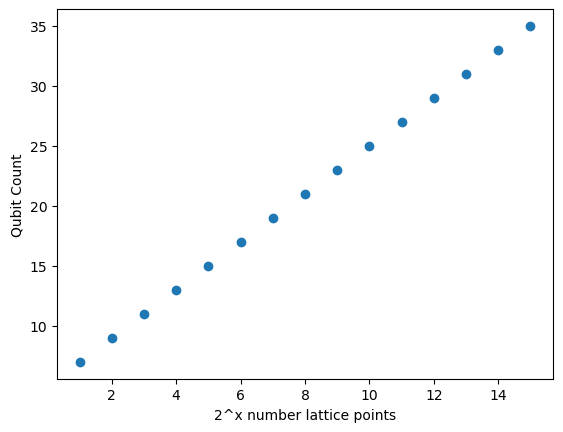

In [ ]:
stop

In [ ]:
min = 5
max = 5

path = "data/oneCircuitECRCounts.txt"

for i in range(min, max + 1):
    print(i)
    #parameters

    M = int(math.pow(2, i)) # lattices

    dim = 2
    dirs = 5

    nlat = int(np.ceil(np.log2(M)))
    nlinks = int(np.ceil(np.log2(dirs)))
    
    #center, right, left, up, down
    wts = (2/6,1/6,1/6,1/6,1/6)
    e = (0,-1,1,-1,1) 
    cs = np.sqrt(3) 
    U = 1 #velocity of moving wall for cavity flow    

    n = nlat+nlat+nlinks+1+1 # number qubits

    allvorts = [np.zeros((M,M))]
    allstreams = [np.zeros((M,M))]

    v, s = allvorts[-1].flatten(), allstreams[-1].flatten()

    part1, part2 = createCirc(s)

    qc = QuantumCircuit(part1.num_qubits)
    qc.append(part1, list(range(part1.num_qubits)))
    qc.append(part2, list(range(part2.num_qubits)))

    print('optimizing')
    pm = generate_preset_pass_manager(backend=backend, optimization_level = 3)
    print("running")
    qc_opt = pm.run(qc)

    with open(path, 'a') as f:
        f.write(f"OUTPUT FOR: 2^{i}\n")
        f.write(f"Transpiled QLBM circuit depth on IBM Brisbane: {qc_opt.depth()}\n")
        f.write(f"Transpiled QLBM circuit ops on IBM Brisbane: {qc_opt.count_ops()}\n")

    print("scheduling")
    sched = schedule(qc_opt, backend)

    with open(path, 'a') as f:
        f.write("Transpiled QLBM circuit physical runtime = {:.2f} micro seconds\n".format(sched.duration*backend.dt*1e6))
        f.write("\n")

5
15


/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


optimizing
running
scheduling


In [ ]:
# # least busy backend we have access to
# backend = service.least_busy(simulator=False, operational=True)
# print(backend)
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_circuit = pm.run(qc)
# print("Pass manager done")
# sampler = Sampler(backend)
# job = sampler.run([isa_circuit])
# print(job.usage_estimation)
# # NOTE: this experiment was scratched due to job vs. circuit estimation